In [1]:
import xarray as xr
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import os
from netCDF4 import Dataset
import h5py
from matplotlib import pyplot as plt
import wradlib as wrl

In [34]:
years = [2019]
months = [5,6]
files = []
for year in years:
    path = f"../data/RYDL/processed/{year}/"

    for month in months:
        monthly_files = os.listdir(path + f"{month:02d}")
        for f in monthly_files:
            if f.endswith(".nc"):
                files.append(path + f"{month:02d}/" + f)

In [86]:
radolan_grid_xy = wrl.georef.get_radolan_grid(1100, 900)
print(
    "{0}, ({1:.4f}, {2:.4f})".format(radolan_grid_xy.shape, *radolan_grid_xy[0, 0, :])
)

(1100, 900, 2), (-443.4622, -4758.6447)


In [57]:
test = xr.open_mfdataset(files, chunks = "auto")
test

<xarray.Dataset> Size: 70GB
Dimensions:  (time: 17568, y: 1100, x: 900)
Coordinates:
  * x        (x) float64 7kB -4.43e+05 -4.42e+05 -4.41e+05 ... 4.55e+05 4.56e+05
  * y        (y) float64 9kB -4.758e+06 -4.757e+06 ... -3.66e+06 -3.659e+06
    lat      (y, x) float64 8MB dask.array<chunksize=(1100, 900), meta=np.ndarray>
    lon      (y, x) float64 8MB dask.array<chunksize=(1100, 900), meta=np.ndarray>
  * time     (time) datetime64[ns] 141kB 2019-05-01 ... 2019-06-30T23:55:00
Data variables:
    crs      (time) int32 70kB -2147483647 -2147483647 ... -2147483647
    RR       (time, y, x) float32 70GB dask.array<chunksize=(33, 1100, 900), meta=np.ndarray>
Attributes:
    title:        RADKLIM - radar-based precipitation climatology
    institution:  Deutscher Wetterdienst (DWD)
    history:      Created at 2021-07-09 12:45:48.979727
    reference:    10.5676/DWD/RADKLIM_YW_V2017.002
    Conventions:  CF-1.6
    Author:       Harald Rybka, Katharina Lengfeld

In [82]:
# Filter domain
data = data.isel(y = slice(88,-100), x = slice(135,-85))
# Precipitation data
precip = data.RR.fillna(0)
x = precip.coords["x"].values
y = precip.coords["y"].values
t =  np.arange(0, 5*2*(8), 5*2)
train = precip.sel(time = range[0:8])
target = precip.sel(time = range[8:])

In [83]:
grid = np.stack(np.meshgrid(y, t, x))

In [4]:
path = "../data/RYDL/processed/2021/05/"
files = os.listdir(path)
files = [path + f for f in files]
files
test = xr.open_mfdataset(files)

threshold = 0.125 / 20

In [ ]:
xy.time

<xarray.DataArray 'time' (time: 4464)> Size: 36kB
array(['2021-05-01T00:00:00.000000000', '2021-05-01T00:10:00.000000000',
       '2021-05-01T00:20:00.000000000', ..., '2021-05-31T23:30:00.000000000',
       '2021-05-31T23:40:00.000000000', '2021-05-31T23:50:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 36kB 2021-05-01 ... 2021-05-31T23:50:00
Attributes:
    long_name:      Time
    standard_name:  time

In [54]:
precip = test.RR.fillna(0)[:,90:-105,135:-85]
filtered = xr.where(precip > threshold, 1, 0).mean(dim = ["x", "y"])


In [55]:
final = filtered[(filtered > 0.1).compute()]

In [56]:
final.time.to_numpy().shape

(3981,)

In [112]:
# Prepare datetime list
init_steps = 12
prediction_steps = 12

times_raw= final.time.to_numpy()
length = len(times_raw) - prediction_steps-1
time_list = []
for i in range(length):
    diff = np.timedelta64(times_raw[i+prediction_steps-1] - times_raw[i-init_steps], "s")
    if diff.astype("int") == (init_steps+prediction_steps-1)*5*60:
        time_list.append(times_raw[i - init_steps])

In [19]:
init_steps = 8
prediction_steps = 8
time_list = np.load("../data/RYDL/train.npy")
len(time_list)

1543

In [20]:
idx = 349
t1 = time_list[idx]
t2 = time_list[idx] + np.timedelta64(5*2*(init_steps+prediction_steps-1), "m")

t1

numpy.datetime64('2019-05-02T23:50:00.000000000')

In [21]:
ab = pd.to_datetime(str(t1))
ab.year

2019

In [22]:
s1 = pd.to_datetime(str(t1)).strftime("%Y%m%d")
s2 = pd.to_datetime(str(t2)).strftime("%Y%m%d")

if s1 == s2:
    test = xr.open_dataset(f"../data/RYDL/processed/2018/05/YW_2017.002_{s1}.nc")
else:
    test = xr.open_mfdataset([f"../data/RYDL/processed/2019/05/YW_2017.002_{s1}.nc", f"../data/RYDL/processed/2019/05/YW_2017.002_{s2}.nc"])
    

#days = [, pd.to_datetime(str(t2)).strftime("%Y%m%d")]
#days = ["../data/RYDL/processed/2018/05/" + f"YW_2017.002_{d}.nc" for d in days]

In [23]:
range = pd.date_range(t1, t2, freq=f"{5 *2}min")

In [24]:
len(range[0:init_steps]), len(range[init_steps:])

(8, 8)

In [117]:
t = np.arange(0, 5*2*(prediction_steps), 5*2)
t

array([ 0, 10, 20, 30, 40, 50, 60, 70])

In [101]:
test.sel(time = range).time

<xarray.DataArray 'time' (time: 16)> Size: 128B
array(['2019-05-02T23:50:00.000000000', '2019-05-03T00:00:00.000000000',
       '2019-05-03T00:10:00.000000000', '2019-05-03T00:20:00.000000000',
       '2019-05-03T00:30:00.000000000', '2019-05-03T00:40:00.000000000',
       '2019-05-03T00:50:00.000000000', '2019-05-03T01:00:00.000000000',
       '2019-05-03T01:10:00.000000000', '2019-05-03T01:20:00.000000000',
       '2019-05-03T01:30:00.000000000', '2019-05-03T01:40:00.000000000',
       '2019-05-03T01:50:00.000000000', '2019-05-03T02:00:00.000000000',
       '2019-05-03T02:10:00.000000000', '2019-05-03T02:20:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 128B 2019-05-02T23:50:00 ... 2019-05-03T02...
Attributes:
    long_name:      Time
    standard_name:  time

In [51]:
xr.open_mfdataset(days)

ValueError: Could not find any dimension coordinates to use to order the datasets for concatenation

In [35]:
idx = 10
t1 = time_list[idx]
t2 = time_list[idx] + np.timedelta64(5*2*(init_steps+prediction_steps), "m")

In [39]:
t1

numpy.datetime64('2018-05-10T12:00:00.000000000')

In [38]:
dates = pd.date_range(t1, t2, freq = "10min")

In [150]:
test_idx = np.random.randint(0, len(time_list))


t1 = time_list[test_idx-8]
t2 = time_list[test_idx+8-1]

In [151]:
dates = pd.date_range(t1, t2, freq = "10min")

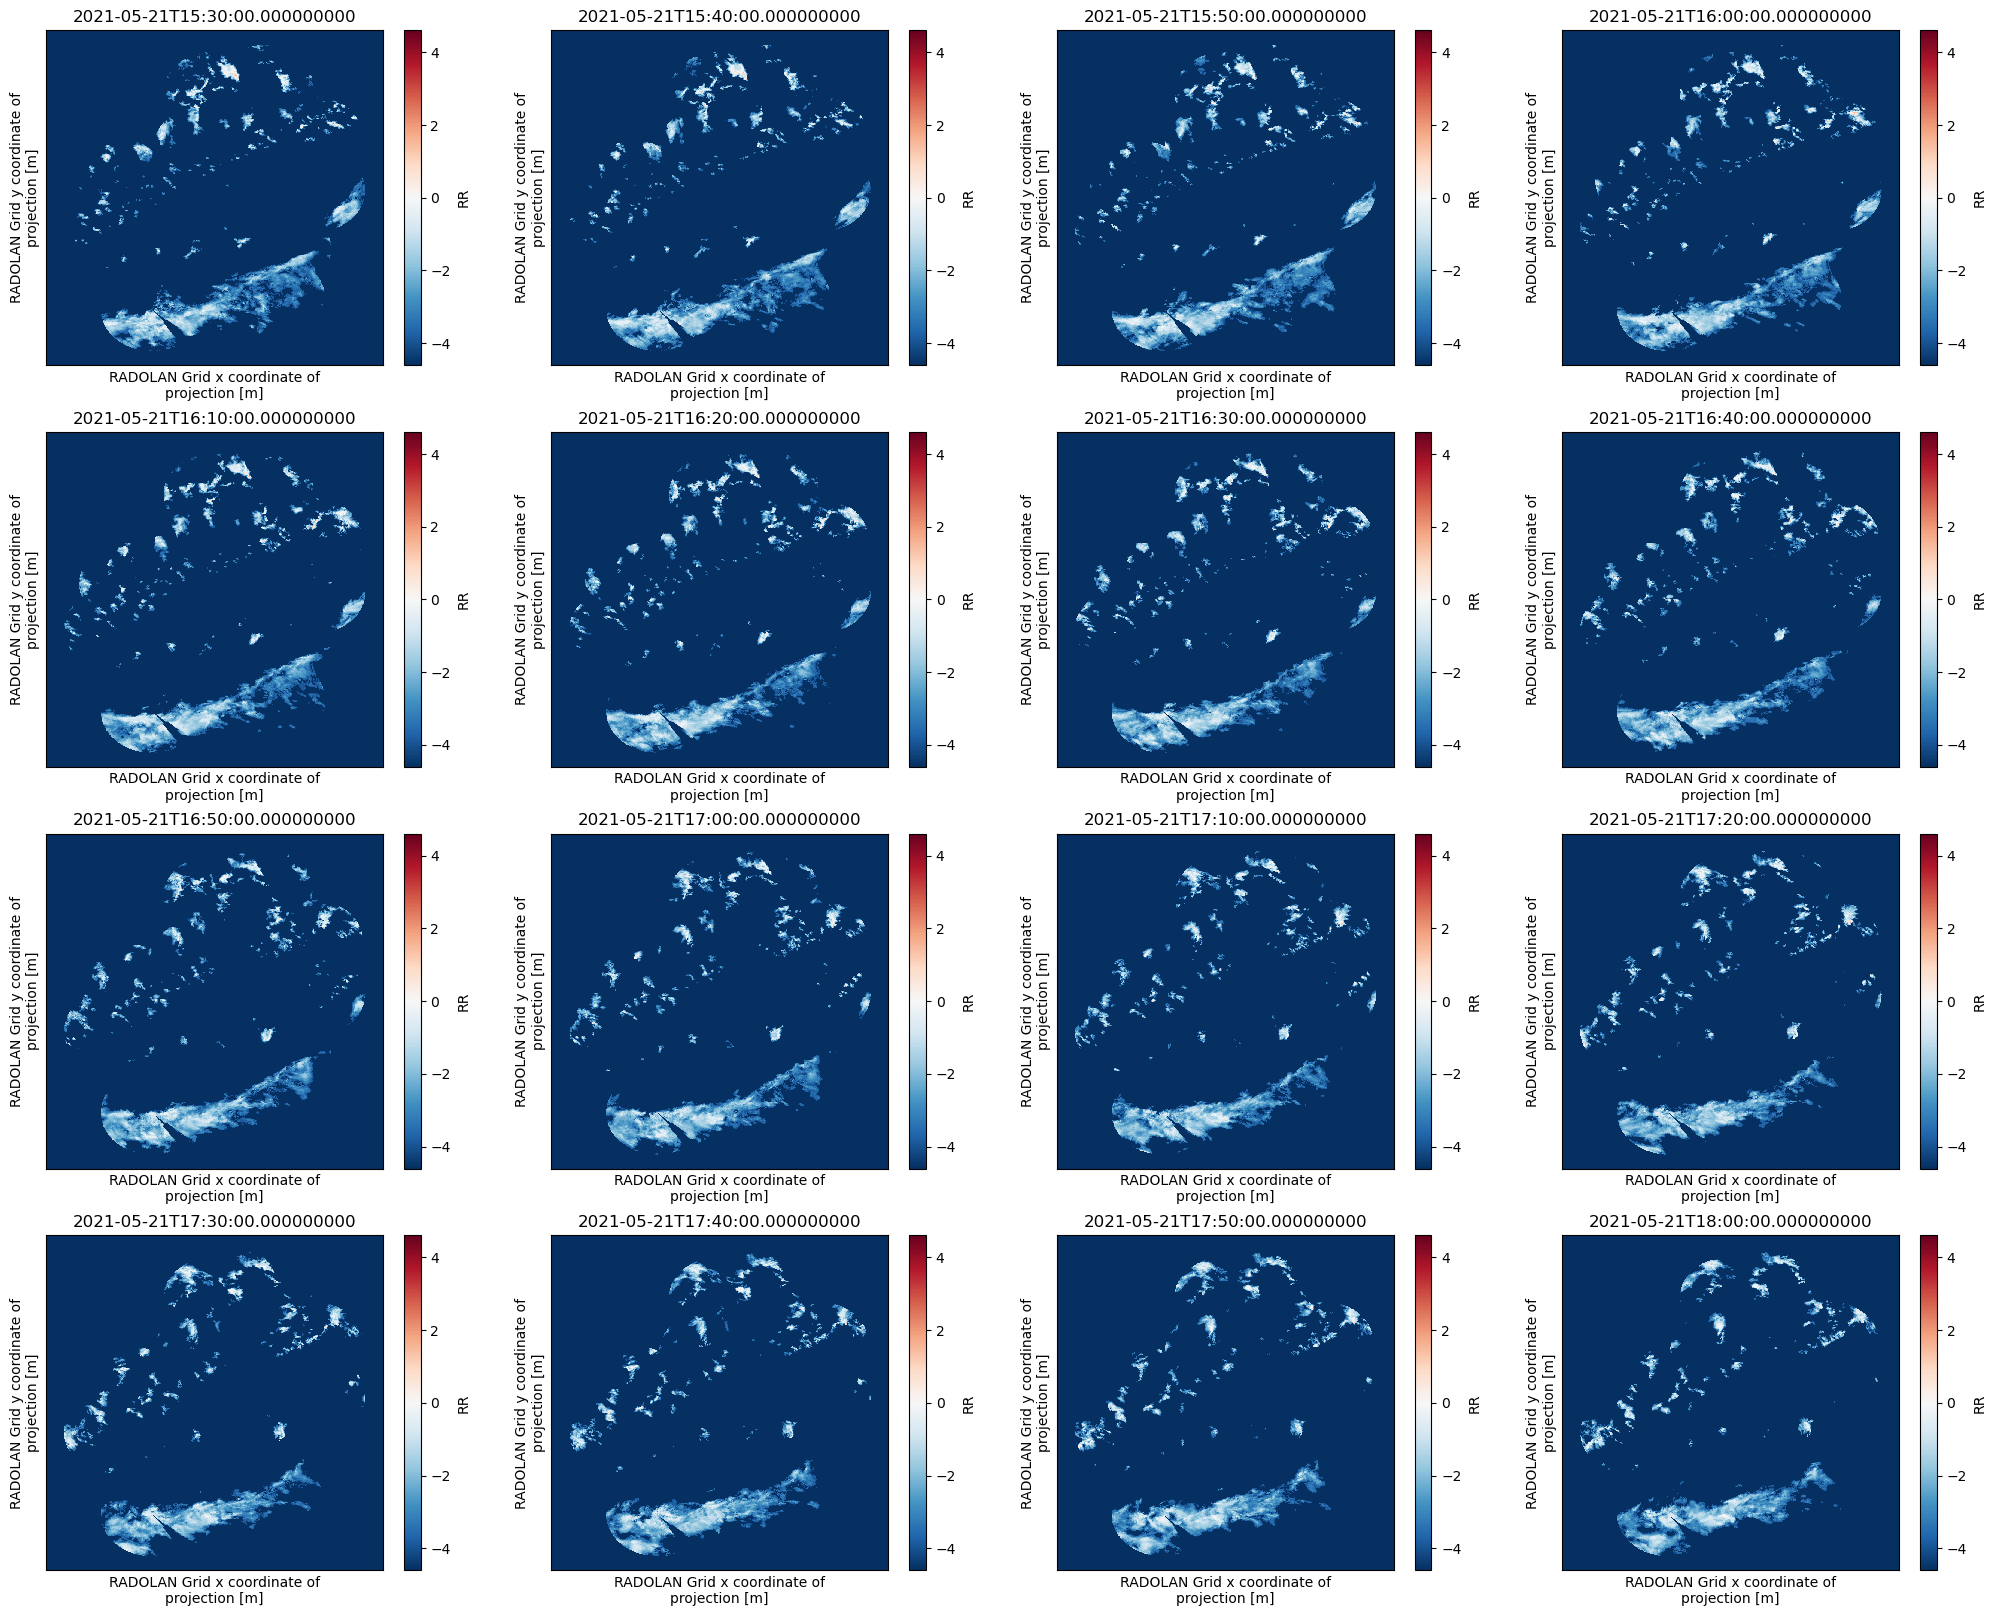

In [152]:
# Plot all precipitation fields

fig, axs = plt.subplots(4,4, figsize = (25,20))
axs = axs.ravel()
data = np.log(test.RR.sel(time = dates).fillna(0)+0.01)
for i in range(16):
    data[i].plot(ax = axs[i])
    axs[i].set_title(data.time[i].values)
    axs[i].set_xticks([])
    axs[i].set_yticks([])


In [16]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

map_proj = ccrs.Stereographic(
    true_scale_latitude=60.0, central_latitude=90.0, central_longitude=10.0
)

subset = test.isel(time = 0).RR
#subset = subset[90:-105,135:-85]
print(subset.shape)

(905, 680)


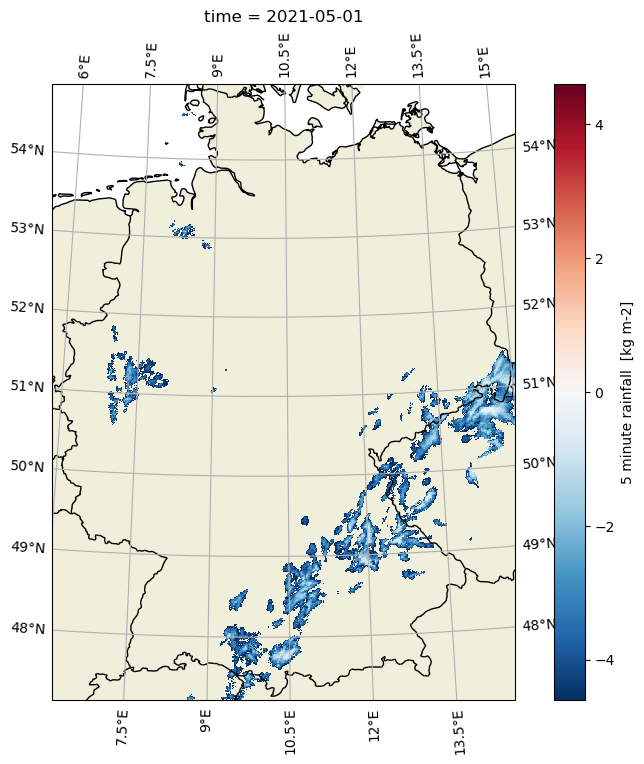

In [17]:
fig = plt.figure(figsize=(10, 8))
np.log(subset).plot(subplot_kws=dict(projection=map_proj))
ax = plt.gca()
ax.gridlines(draw_labels=True, y_inline=False)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)

In [28]:
radolan_grid_xy = wrl.georef.get_radolan_grid(900, 900, wgs84=True)
x = [radolan_grid_xy[0,0,0], radolan_grid_xy[0,-1,0]]
y = [radolan_grid_xy[0,0,1], radolan_grid_xy[-1,0,1]]
print(x,y)

[3.588929950917963, 14.608702502626649] [46.95258041119031, 54.57904570041962]


In [29]:
radolan_grid_xy = wrl.georef.get_radolan_grid(1100, 900, wgs84=True)
x = [radolan_grid_xy[0,0,0], radolan_grid_xy[0,-1,0]]
y = [radolan_grid_xy[0,0,1], radolan_grid_xy[-1,0,1]]
print(x,y)

[4.675934176579067, 15.468175240935931] [46.19287861255967, 55.53947933382205]
